## 0. Environment Setup (Kaggle)

**For Kaggle users:** This cell clones the GitHub repository to get the code and processed data files.

**For local users:** Skip this cell - your files are already present.

In [1]:
# Check if running on Kaggle
import os
from pathlib import Path

if Path('/kaggle/input').exists():
    print("Running on Kaggle - Setting up environment...")
    
    # Clone repository if not already present
    repo_path = Path('/kaggle/working/MCIM_Final_Project')
    
    if not repo_path.exists():
        print("Cloning GitHub repository...")
        !git clone https://github.com/miguel-silva48/MCIM_Final_Project.git
        print("✓ Repository cloned successfully")
    else:
        print("✓ Repository already exists")
    
    # Change to notebooks directory
    os.chdir('/kaggle/working/MCIM_Final_Project/notebooks')
    print(f"✓ Working directory: {Path.cwd()}")
    
    # Install requirements if they exist
    requirements_file = Path('../requirements_kaggle.txt')
    if requirements_file.exists():
        print("\nInstalling requirements...")
        !pip install -q -r {requirements_file}
        print("✓ Requirements installed")
    else:
        print("\nWarning: requirements_kaggle.txt not found")
        print("Installing essential packages...")
        !pip install -q rouge-score nltk
        print("✓ Essential packages installed")
else:
    print("Running locally - skipping Kaggle setup")


# Switch preprocessing variant (edit this for each run)
VARIANT = 'pairs_impression_3'  # Change this for different runs

import yaml
config_path = '/kaggle/working/MCIM_Final_Project/configs/model_config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
config['paths']['preprocessing_variant'] = VARIANT
with open(config_path, 'w') as f:
    yaml.dump(config, f)
print(f"✓ Using variant: {VARIANT}")

Running on Kaggle - Setting up environment...
Cloning GitHub repository...
Cloning into 'MCIM_Final_Project'...
remote: Enumerating objects: 296, done.
remote: Counting objects: 100% (296/296), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 296 (delta 130), reused 266 (delta 104), pack-reused 0 (from 0)
Receiving objects: 100% (296/296), 19.25 MiB | 41.50 MiB/s, done.
Resolving deltas: 100% (130/130), done.
✓ Repository cloned successfully
✓ Working directory: /kaggle/working/MCIM_Final_Project/notebooks

Installing requirements...
  Preparing metadata (setup.py) ... done
✓ Requirements installed
✓ Using variant: pairs_impression_3


## 1. Setup & Imports

In [2]:
# Standard library
import os
import sys
import time
import json
import yaml
from pathlib import Path
from datetime import datetime

# Add src to path for imports
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root))

# Import environment utilities early
from src.utils import print_environment_info

# Print environment info
print_environment_info()
print(f"\nProject root: {project_root}")
print(f"Working directory: {Path.cwd()}")

# Data handling
import pandas as pd
import numpy as np
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Imports successful!")
print(f"PyTorch version: {torch.__version__}")

ENVIRONMENT INFORMATION
Environment: KAGGLE
Kaggle input directory: /kaggle/input
Kaggle working directory: /kaggle/working

Available datasets (1):
  - chest-xrays-indiana-university

Project root: /kaggle/working/MCIM_Final_Project
Working directory: /kaggle/working/MCIM_Final_Project/notebooks
Imports successful!
PyTorch version: 2.8.0+cu126


## 2. Configuration Loading

Load model and training configuration from YAML file.

In [3]:
# Load configuration with automatic type conversion
from src.utils import load_config

config_path = '../configs/model_config.yaml'
config = load_config(config_path)

print("Configuration loaded successfully!")
print("\n" + "="*70)
print("KEY CONFIGURATION")
print("="*70)

# Model config
print(f"\nModel Architecture:")
print(f"  Encoder: {config['model']['encoder']['architecture']}")
print(f"  Decoder: {config['model']['decoder']['type']}")
print(f"  Attention: {config['model']['decoder']['attention']['type']}")
print(f"  Embedding dim: {config['model']['decoder']['embedding_dim']}")
print(f"  Hidden dim: {config['model']['decoder']['hidden_dim']}")

# Training config
print(f"\nTraining Configuration:")
print(f"  Epochs: {config['training']['num_epochs']}")
print(f"  Batch size: {config['training']['batch_size']} (will auto-adjust)")
print(f"  Learning rate: {config['training']['optimizer']['learning_rate']}")
print(f"  Early stopping patience: {config['training']['early_stopping']['patience']}")

# Inference config
print(f"\nInference Configuration:")
print(f"  Method: {config['inference']['decoding']['method']}")
print(f"  Beam size: {config['inference']['decoding']['beam_size']}")
print(f"  Max length: {config['inference']['decoding']['max_length']}")

Configuration loaded successfully!

KEY CONFIGURATION

Model Architecture:
  Encoder: densenet121
  Decoder: lstm
  Attention: bahdanau
  Embedding dim: 512
  Hidden dim: 1024

Training Configuration:
  Epochs: 30
  Batch size: 32 (will auto-adjust)
  Learning rate: 0.0001
  Early stopping patience: 10

Inference Configuration:
  Method: beam_search
  Beam size: 3
  Max length: 50


## 3. Device Detection & Setup

Automatically detect and configure the best available device (CUDA/MPS/CPU).

In [4]:
# Import device utilities
from src.utils import get_device, get_device_info, print_device_info

# Detect device
device = get_device()
device_info = get_device_info()

# Print device information
print_device_info()

# Update configuration with device info
config['device'] = device_info

# Adjust batch size based on GPU memory
if device_info['device_type'] == 'cuda':
    gpu_memory_gb = device_info.get('memory_total_gb', 16)
    if gpu_memory_gb <= 4:
        config['training']['batch_size'] = 4
        config['training']['gradient_accumulation_steps'] = 8
        print("\nSmall GPU detected (4GB) - adjusted batch_size=4, gradient_accumulation=8")
    elif gpu_memory_gb <= 8:
        config['training']['batch_size'] = 16
        config['training']['gradient_accumulation_steps'] = 2
        print("\nMedium GPU detected (8GB) - adjusted batch_size=16, gradient_accumulation=2")
    else:
        config['training']['batch_size'] = 32
        print("\n✓ Large GPU detected (16GB+) - using batch_size=32")
elif device_info['device_type'] == 'mps':
    config['training']['batch_size'] = 16
    config['training']['mixed_precision'] = False
    print("\nMPS device - adjusted batch_size=16, disabled mixed precision")
else:
    config['training']['batch_size'] = 8
    config['training']['mixed_precision'] = False
    print("\nCPU device - adjusted batch_size=8, disabled mixed precision")
print(f"\nFinal batch size: {config['training']['batch_size']}")

Device Configuration
PyTorch version: 2.8.0+cu126
Device type: cuda
Device name: Tesla P100-PCIE-16GB
CUDA version: 12.6
Device count: 1
Memory (total): 15.89 GB
Memory (available): 15.89 GB
Mixed precision support: True
Selected device: cuda

Recommended batch size: 32
  (Based on 15.9GB memory)

✓ Large GPU detected (16GB+) - using batch_size=32

Final batch size: 32


## 4. Data Loading

Load preprocessed data splits and create PyTorch Datasets and DataLoaders.

In [5]:
# Import data utilities
from src.data import Vocabulary, get_transforms, ChestXrayDataset, collate_fn
from src.utils import get_data_paths, get_execution_env

# Get paths based on environment (local vs Kaggle vs Colab)
print("\nDetecting data paths...")
data_paths = get_data_paths(
    preprocessing_variant=config['paths']['preprocessing_variant'],
    project_root=project_root,
    kaggle_dataset_name='chest-xrays-indiana-university'
)

vocab_file = data_paths['vocab_file']
train_csv = data_paths['train_csv']
val_csv = data_paths['val_csv']
test_csv = data_paths['test_csv']
image_dir = data_paths['image_dir']

print(f"Environment: {get_execution_env().upper()}")
print(f"Data root: {data_paths['data_root']}")
print(f"Image directory: {image_dir}")
# Verify files exist
for name, path in [('vocab', vocab_file), ('train', train_csv), ('val', val_csv), ('test', test_csv), ('images', image_dir)]:
    if not path.exists():
        raise FileNotFoundError(f"Required file not found ({name}): {path}")

print("✓ All data files found")

# Load vocabulary
print("\nLoading vocabulary...")
vocabulary = Vocabulary(str(vocab_file))
print(f"✓ Vocabulary loaded: {len(vocabulary)} tokens")

# Update config with vocab size
config['model']['decoder']['vocab_size'] = len(vocabulary)

# Create transforms
print("\nCreating image transforms...")
train_transform = get_transforms(
    image_size=config['data']['image_size'],
    mode='train',
    normalize_mean=config['data']['normalize']['mean'],
    normalize_std=config['data']['normalize']['std'],
    rotation_degrees=config['data']['augmentation']['random_rotation_degrees'],
    color_jitter=config['data']['augmentation']['color_jitter']
)

val_transform = get_transforms(
    image_size=config['data']['image_size'],
    mode='val',
    normalize_mean=config['data']['normalize']['mean'],
    normalize_std=config['data']['normalize']['std']
)

print("✓ Transforms created")


Detecting data paths...
Environment: KAGGLE
Data root: /kaggle/input/chest-xrays-indiana-university
Image directory: /kaggle/input/chest-xrays-indiana-university/images/images_normalized
✓ All data files found

Loading vocabulary...
✓ Vocabulary loaded: 898 tokens

Creating image transforms...
✓ Transforms created


In [6]:
# Create datasets
print("\nCreating datasets...")

train_dataset = ChestXrayDataset(
    csv_file=str(train_csv),
    image_dir=str(image_dir),
    vocabulary=vocabulary,
    transform=train_transform,
    max_caption_length=config['data']['max_caption_length']
)

val_dataset = ChestXrayDataset(
    csv_file=str(val_csv),
    image_dir=str(image_dir),
    vocabulary=vocabulary,
    transform=val_transform,
    max_caption_length=config['data']['max_caption_length']
)

test_dataset = ChestXrayDataset(
    csv_file=str(test_csv),
    image_dir=str(image_dir),
    vocabulary=vocabulary,
    transform=val_transform,
    max_caption_length=config['data']['max_caption_length']
)

print(f"✓ Datasets created:")
print(f"    Training: {len(train_dataset)} samples")
print(f"    Validation: {len(val_dataset)} samples")
print(f"    Test: {len(test_dataset)} samples")

# Create dataloaders
print("\nCreating dataloaders...")

train_loader = DataLoader(
    train_dataset,
    batch_size=config['training']['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=config['data']['num_workers'],
    pin_memory=(device_info['device_type'] == 'cuda')
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['training']['batch_size'],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=config['data']['num_workers'],
    pin_memory=(device_info['device_type'] == 'cuda')
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['training']['batch_size'],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=config['data']['num_workers'],
    pin_memory=(device_info['device_type'] == 'cuda')
)

print(f"✓ Dataloaders created:")
print(f"    Training batches: {len(train_loader)}")
print(f"    Validation batches: {len(val_loader)}")
print(f"    Test batches: {len(test_loader)}")


Creating datasets...
✓ Datasets created:
    Training: 5797 samples
    Validation: 721 samples
    Test: 732 samples

Creating dataloaders...
✓ Dataloaders created:
    Training batches: 182
    Validation batches: 23
    Test batches: 23


### Data Sample Verification

Let's verify one batch to ensure everything is loaded correctly.

In [7]:
# Load one batch
images, captions, caption_lengths, image_paths, uids = next(iter(train_loader))

print("Sample batch loaded:")
print(f"  Images: {images.shape}")
print(f"  Captions: {captions.shape}")
print(f"  Lengths: {caption_lengths.tolist()}")
print(f"  UIDs: {uids.tolist()[:5]}... (showing first 5)")

# Decode first caption
print(f"\nFirst caption (UID {uids[0]}):")
caption_text = vocabulary.decode(captions[0].tolist())
print(f"  Text: '{caption_text}'")
print(f"  Length: {caption_lengths[0]} tokens")

Sample batch loaded:
  Images: torch.Size([32, 3, 224, 224])
  Captions: torch.Size([32, 50])
  Lengths: [50, 28, 22, 18, 15, 15, 14, 12, 11, 11, 11, 11, 9, 8, 8, 8, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5]
  UIDs: [973, 1260, 2478, 3064, 3165]... (showing first 5)

First caption (UID 973):
  Text: 'the cardiac silhouette is normal in size and <UNK> mediastinum and perihilar structures remarkable for vascular calcifications involving the aortic <UNK> this is consistent with atherosclerotic <UNK> in <UNK> marked prominence is noted to the pulmonary arteries in the perihilar <UNK> although the heart is not <UNK> this'
  Length: 50 tokens


## 5. Model Initialization

Create the complete encoder-decoder model with attention.

In [8]:
# Import model
from src.models import EncoderDecoderModel

print("Initializing model...")

model = EncoderDecoderModel(
    vocab_size=len(vocabulary),
    embedding_dim=config['model']['decoder']['embedding_dim'],
    encoder_feature_dim=config['model']['encoder']['output_feature_dim'],
    decoder_dim=config['model']['decoder']['hidden_dim'],
    attention_dim=config['model']['decoder']['attention']['attention_dim'],
    attention_type=config['model']['decoder']['attention']['type'],
    dropout=config['model']['decoder']['dropout'],
    encoder_architecture=config['model']['encoder']['architecture'],
    encoder_pretrained=config['model']['encoder']['pretrained'],
    encoder_freeze=config['model']['encoder']['freeze_backbone']
)

# Move to device
model = model.to(device)

print("✓ Model initialized")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters: {frozen_params:,}")
print(f"  Trainable percentage: {100*trainable_params/total_params:.1f}%")

Initializing model...
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 167MB/s]


✓ Model initialized

Model Statistics:
  Total parameters: 23,002,347
  Trainable parameters: 16,048,491
  Frozen parameters: 6,953,856
  Trainable percentage: 69.8%


## 6. Training Setup

Initialize trainer with loss, metrics, checkpointing, and logging.

In [9]:
# Import training utilities
from src.training import CaptionTrainer
from src.utils import get_output_path

print("Initializing trainer...")

# Create trainer with environment-aware output directory
output_dir = get_output_path(project_root=project_root)

trainer = CaptionTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    vocabulary=vocabulary,
    config=config,
    device=str(device),  # Convert torch.device to string
    output_dir=str(output_dir),
    resume_checkpoint=None  # Set to checkpoint path if resuming
)

print("✓ Trainer initialized")
print(f"  Output directory: {trainer.output_dir}")
print(f"  Mixed precision: {trainer.use_amp}")
print(f"  Early stopping: {config['training']['early_stopping']['enabled']}")

Initializing trainer...
✓ Trainer initialized
  Output directory: /kaggle/working/outputs/pairs_impression_3_20260106_201158
  Mixed precision: True
  Early stopping: True


## 7. Training

The training loop includes:
- Teacher forcing with ground truth
- Validation every epoch with beam search
- Sample caption generation
- Automatic checkpointing (best model + last N epochs)
- Early stopping if validation metric doesn't improve

In [10]:
# Train the model
print("=" * 70)
print("STARTING TRAINING")
print("=" * 70)
print(f"Configuration: {config['training']['num_epochs']} epochs, batch_size={config['training']['batch_size']}")
print(f"Device: {device}")
print(f"Output: {trainer.output_dir}")
print("=" * 70)

# Start training
start_time = time.time()
trainer.train()
total_time = time.time() - start_time

print(f"\n{'=' * 70}")
print("TRAINING COMPLETE")
print(f"{'=' * 70}")
print(f"Total training time: {total_time/3600:.2f} hours ({total_time/60:.1f} minutes)")
print(f"Output directory: {trainer.output_dir}")

STARTING TRAINING
Configuration: 30 epochs, batch_size=32
Device: cuda
Output: /kaggle/working/outputs/pairs_impression_3_20260106_201158
Starting training for 30 epochs
Output directory: /kaggle/working/outputs/pairs_impression_3_20260106_201158
Device: cuda
Mixed precision: True
Batch size: 32


Epoch 1 [Val]: 100%|██████████| 23/23 [01:06<00:00,  2.88s/it]



Epoch 1/30 (234.5s):
  Train Loss: 4.3204, Perplexity: 95.90
  Val BLEU-4: 0.0326, METEOR: 0.2416
  Learning Rate: 0.000100


Epoch 2 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.81s/it]



Epoch 2/30 (217.4s):
  Train Loss: 3.7721, Perplexity: 44.79
  Val BLEU-4: 0.0323, METEOR: 0.2798
  Learning Rate: 0.000100


Epoch 3 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.82s/it]



Epoch 3/30 (218.6s):
  Train Loss: 3.5241, Perplexity: 35.21
  Val BLEU-4: 0.0338, METEOR: 0.2694
  Learning Rate: 0.000100


Epoch 4 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.80s/it]



Epoch 4/30 (217.0s):
  Train Loss: 3.3301, Perplexity: 28.85
  Val BLEU-4: 0.0340, METEOR: 0.2573
  Learning Rate: 0.000100


Epoch 5 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.81s/it]



Epoch 5/30 (216.7s):
  Train Loss: 3.1681, Perplexity: 24.44
  Val BLEU-4: 0.0337, METEOR: 0.2560
  Learning Rate: 0.000100


Epoch 6 [Val]: 100%|██████████| 23/23 [01:05<00:00,  2.83s/it]



Epoch 6/30 (217.8s):
  Train Loss: 3.0208, Perplexity: 21.10
  Val BLEU-4: 0.0338, METEOR: 0.2451
  Learning Rate: 0.000100


Epoch 7 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.81s/it]



Epoch 7/30 (217.3s):
  Train Loss: 2.8989, Perplexity: 18.70
  Val BLEU-4: 0.0363, METEOR: 0.2667
  Learning Rate: 0.000100


Epoch 8 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.82s/it]



Epoch 8/30 (217.5s):
  Train Loss: 2.7830, Perplexity: 16.56
  Val BLEU-4: 0.0373, METEOR: 0.2512
  Learning Rate: 0.000100


Epoch 9 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.82s/it]



Epoch 9/30 (218.3s):
  Train Loss: 2.6856, Perplexity: 14.96
  Val BLEU-4: 0.0369, METEOR: 0.2572
  Learning Rate: 0.000100


Epoch 10 [Val]: 100%|██████████| 23/23 [01:05<00:00,  2.85s/it]



Epoch 10/30 (217.9s):
  Train Loss: 2.5907, Perplexity: 13.64
  Val BLEU-4: 0.0352, METEOR: 0.2597
  Learning Rate: 0.000100


Epoch 11 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.81s/it]



Epoch 11/30 (217.2s):
  Train Loss: 2.4996, Perplexity: 12.39
  Val BLEU-4: 0.0362, METEOR: 0.2612
  Learning Rate: 0.000100


Epoch 12 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.80s/it]



Epoch 12/30 (216.6s):
  Train Loss: 2.4165, Perplexity: 11.38
  Val BLEU-4: 0.0374, METEOR: 0.2508
  Learning Rate: 0.000100


Epoch 13 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.82s/it]



Epoch 13/30 (217.8s):
  Train Loss: 2.3290, Perplexity: 10.43
  Val BLEU-4: 0.0364, METEOR: 0.2630
  Learning Rate: 0.000100


Epoch 14 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.81s/it]



Epoch 14/30 (217.1s):
  Train Loss: 2.2514, Perplexity: 9.66
  Val BLEU-4: 0.0354, METEOR: 0.2578
  Learning Rate: 0.000100


Epoch 15 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.80s/it]



Epoch 15/30 (216.7s):
  Train Loss: 2.1855, Perplexity: 9.00
  Val BLEU-4: 0.0356, METEOR: 0.2557
  Learning Rate: 0.000100


Epoch 16 [Val]: 100%|██████████| 23/23 [01:05<00:00,  2.85s/it]



Epoch 16/30 (217.9s):
  Train Loss: 2.1145, Perplexity: 8.36
  Val BLEU-4: 0.0368, METEOR: 0.2641
  Learning Rate: 0.000100


Epoch 17 [Val]: 100%|██████████| 23/23 [01:05<00:00,  2.85s/it]



Epoch 17/30 (219.4s):
  Train Loss: 2.0509, Perplexity: 7.85
  Val BLEU-4: 0.0335, METEOR: 0.2582
  Learning Rate: 0.000100


Epoch 18 [Val]: 100%|██████████| 23/23 [01:05<00:00,  2.83s/it]



Epoch 18/30 (218.3s):
  Train Loss: 1.9813, Perplexity: 7.33
  Val BLEU-4: 0.0360, METEOR: 0.2561
  Learning Rate: 0.000100


Epoch 19 [Val]: 100%|██████████| 23/23 [01:05<00:00,  2.83s/it]



Epoch 19/30 (218.5s):
  Train Loss: 1.9263, Perplexity: 6.92
  Val BLEU-4: 0.0353, METEOR: 0.2575
  Learning Rate: 0.000100


Epoch 20 [Val]: 100%|██████████| 23/23 [01:05<00:00,  2.83s/it]



Epoch 20/30 (217.5s):
  Train Loss: 1.8328, Perplexity: 6.29
  Val BLEU-4: 0.0354, METEOR: 0.2599
  Learning Rate: 0.000050


Epoch 21 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.81s/it]



Epoch 21/30 (216.9s):
  Train Loss: 1.7819, Perplexity: 5.98
  Val BLEU-4: 0.0364, METEOR: 0.2633
  Learning Rate: 0.000050


Epoch 22 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.79s/it]



Epoch 22/30 (215.8s):
  Train Loss: 1.7603, Perplexity: 5.85
  Val BLEU-4: 0.0365, METEOR: 0.2582
  Learning Rate: 0.000050


Epoch 23 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.80s/it]



Epoch 23/30 (216.3s):
  Train Loss: 1.7262, Perplexity: 5.65
  Val BLEU-4: 0.0367, METEOR: 0.2665
  Learning Rate: 0.000050


Epoch 24 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.79s/it]



Epoch 24/30 (215.6s):
  Train Loss: 1.6829, Perplexity: 5.41
  Val BLEU-4: 0.0348, METEOR: 0.2604
  Learning Rate: 0.000025


Epoch 25 [Val]: 100%|██████████| 23/23 [01:04<00:00,  2.80s/it]



Epoch 25/30 (216.0s):
  Train Loss: 1.6633, Perplexity: 5.31
  Val BLEU-4: 0.0358, METEOR: 0.2625
  Learning Rate: 0.000025

Early stopping triggered after 25 epochs
Best val_loss: 3.0719 at epoch 15

Training complete!
Best model: epoch 15, val_loss=3.0719

TRAINING COMPLETE
Total training time: 1.52 hours (91.0 minutes)
Output directory: /kaggle/working/outputs/pairs_impression_3_20260106_201158


## 8. Training Results Visualization

Load training metrics and visualize the results.

In [11]:
# Import visualization utilities
from src.visualization import (
    plot_training_metrics,
    plot_learning_rate,
    plot_sample_predictions,
    plot_epoch_time
)

# Paths
metrics_csv = trainer.output_dir / 'metrics.csv'
viz_dir = trainer.output_dir / 'visualizations'
viz_dir.mkdir(exist_ok=True)

print(f"Loading metrics from: {metrics_csv}")

# Check if metrics file exists
if not metrics_csv.exists():
    print("Metrics file not found. Training may have failed.")
else:
    # Load metrics
    metrics_df = pd.read_csv(metrics_csv)
    print(f"✓ Loaded metrics for {len(metrics_df)} epochs")
    
    # Display metrics table
    print("\n" + "="*70)
    print("TRAINING METRICS SUMMARY")
    print("="*70)
    display(metrics_df)

Loading metrics from: /kaggle/working/outputs/pairs_impression_3_20260106_201158/metrics.csv
✓ Loaded metrics for 25 epochs

TRAINING METRICS SUMMARY


,epoch,step,learning_rate,epoch_time_seconds,train_loss,train_perplexity,val_bleu_1,val_bleu_2,val_bleu_3,val_bleu_4,val_meteor,val_rouge_l,val_loss
0,1,182,0.000100,234.504443,4.320417,95.895196,0.093232,0.064837,0.048258,0.032593,0.241636,0.143443,3.884397
1,2,364,0.000100,217.368527,3.772089,44.789134,0.093343,0.064241,0.047164,0.032328,0.279836,0.146526,3.690012
2,3,546,0.000100,218.590811,3.524061,35.207734,0.099501,0.068540,0.049425,0.033837,0.269361,0.152400,3.534728
3,4,728,0.000100,216.974696,3.330087,28.847291,0.101359,0.069714,0.049635,0.033987,0.257299,0.152358,3.400785
4,5,910,0.000100,216.650573,3.168123,24.438130,0.101942,0.070490,0.049601,0.033715,0.255969,0.153969,3.308198
5,6,1092,0.000100,217.808966,3.020815,21.096326,0.101775,0.070022,0.049717,0.033818,0.245120,0.152737,3.232157
6,7,1274,0.000100,217.297009,2.898884,18.704255,0.102524,0.071831,0.052232,0.036309,0.266680,0.157013,3.190384
7,8,1456,0.000100,217.518208,2.782991,16.560806,0.105465,0.074053,0.053811,0.037321,0.251241,0.158887,3.166899
8,9,1638,0.000100,218.280602,2.685585,14.958826,0.106963,0.074455,0.053665,0.036875,0.257171,0.159448,3.138242
9,10,1820,0.000100,217.916599,2.590723,13.638566,0.103329,0.071604,0.051303,0.035167,0.259670,0.156097,3.109487



Generating visualizations...
Training metrics plot saved to: /kaggle/working/outputs/pairs_impression_3_20260106_201158/visualizations/training_metrics.png


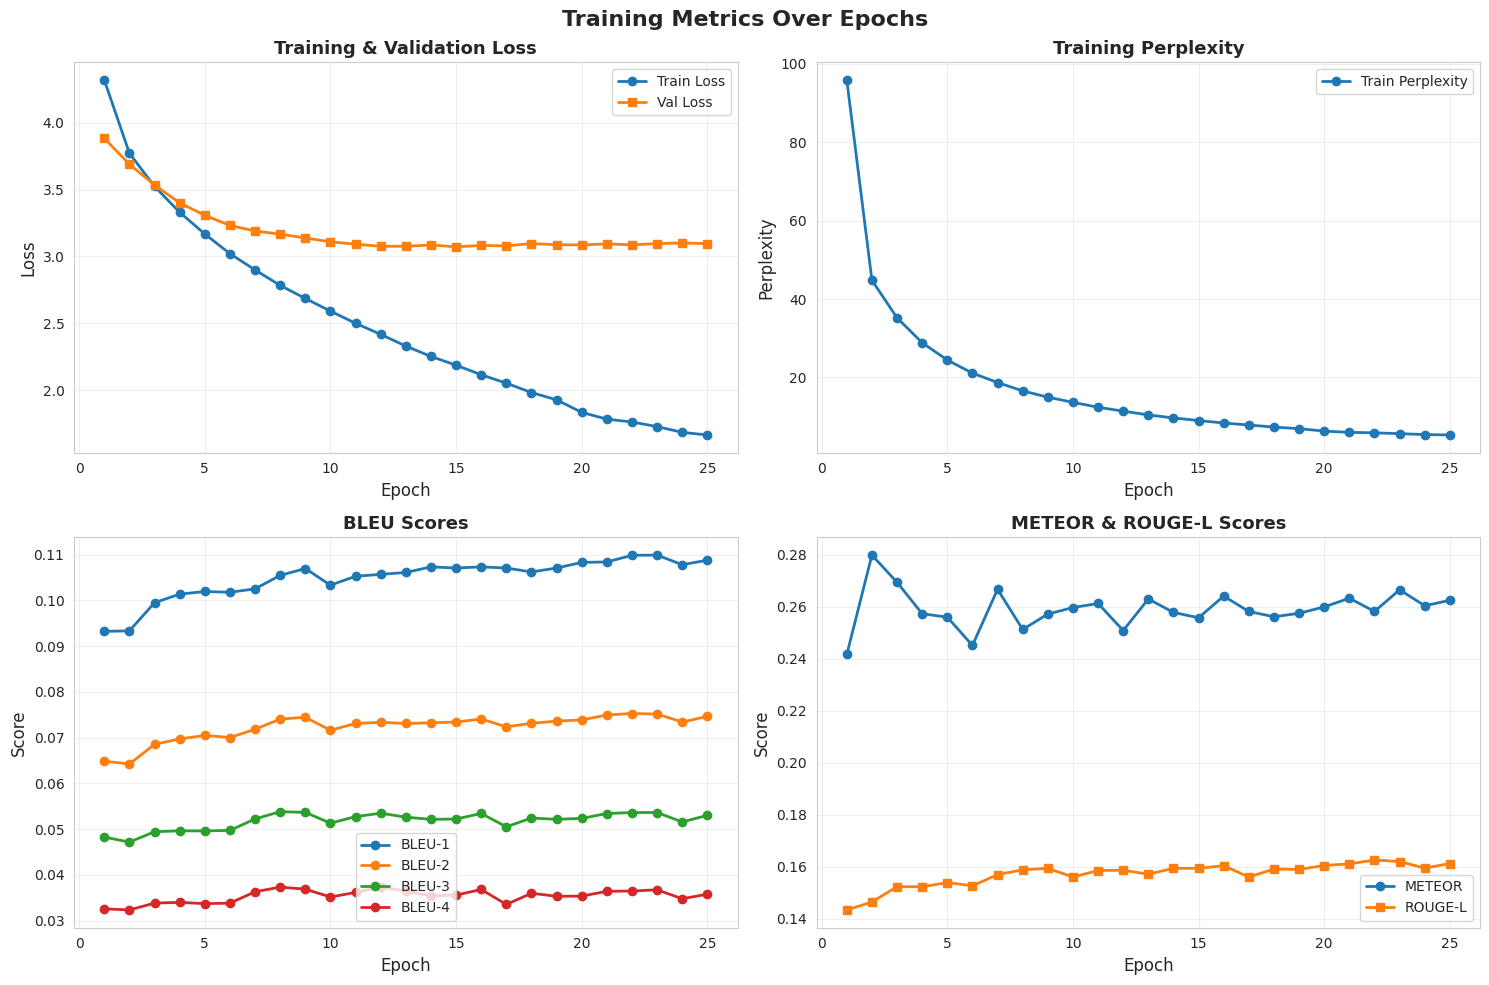

In [12]:
# Plot training metrics
print("\nGenerating visualizations...")

# 1. Training metrics (loss, perplexity, BLEU, METEOR, ROUGE)
fig1 = plot_training_metrics(
    metrics_csv=str(metrics_csv),
    save_path=str(viz_dir / 'training_metrics.png')
)
plt.show()

Learning rate plot saved to: /kaggle/working/outputs/pairs_impression_3_20260106_201158/visualizations/learning_rate.png


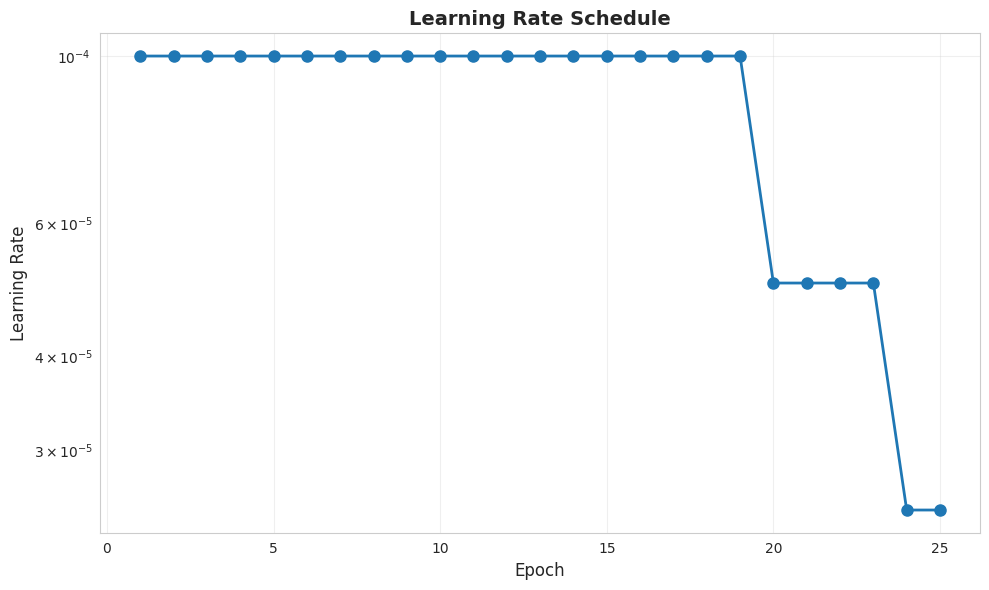

In [13]:
# 2. Learning rate schedule
fig2 = plot_learning_rate(
    metrics_csv=str(metrics_csv),
    save_path=str(viz_dir / 'learning_rate.png')
)
if fig2:
    plt.show()

Epoch time plot saved to: /kaggle/working/outputs/pairs_impression_3_20260106_201158/visualizations/epoch_time.png


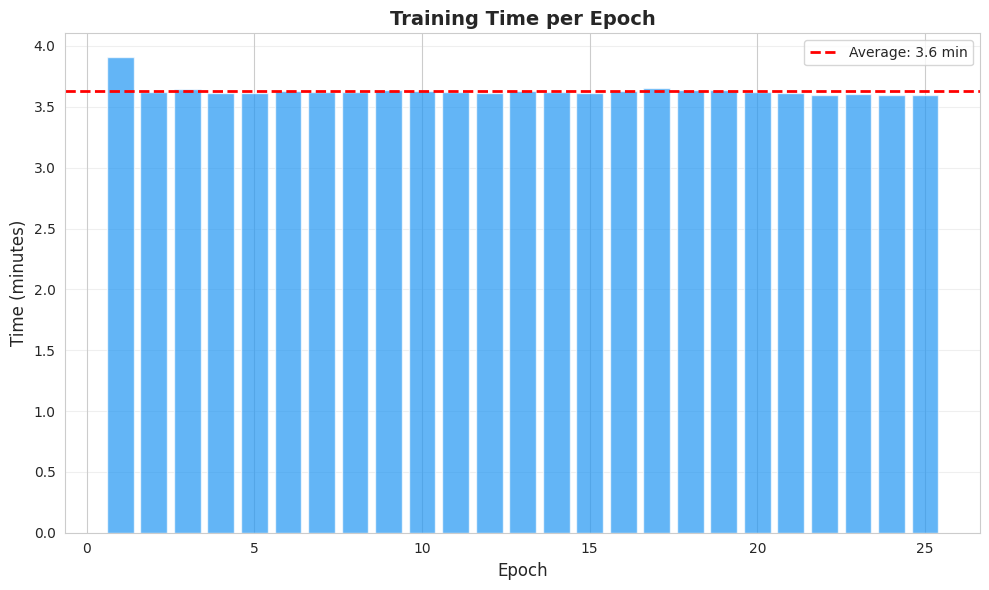

In [14]:
# 3. Epoch time
fig3 = plot_epoch_time(
    metrics_csv=str(metrics_csv),
    save_path=str(viz_dir / 'epoch_time.png')
)
if fig3:
    plt.show()

### Sample Predictions

Load and visualize sample predictions from the final epoch.

Loading samples from: epoch_025_samples.json
Loaded 10 sample predictions
Sample predictions plot saved to: /kaggle/working/outputs/pairs_impression_3_20260106_201158/visualizations/sample_predictions.png


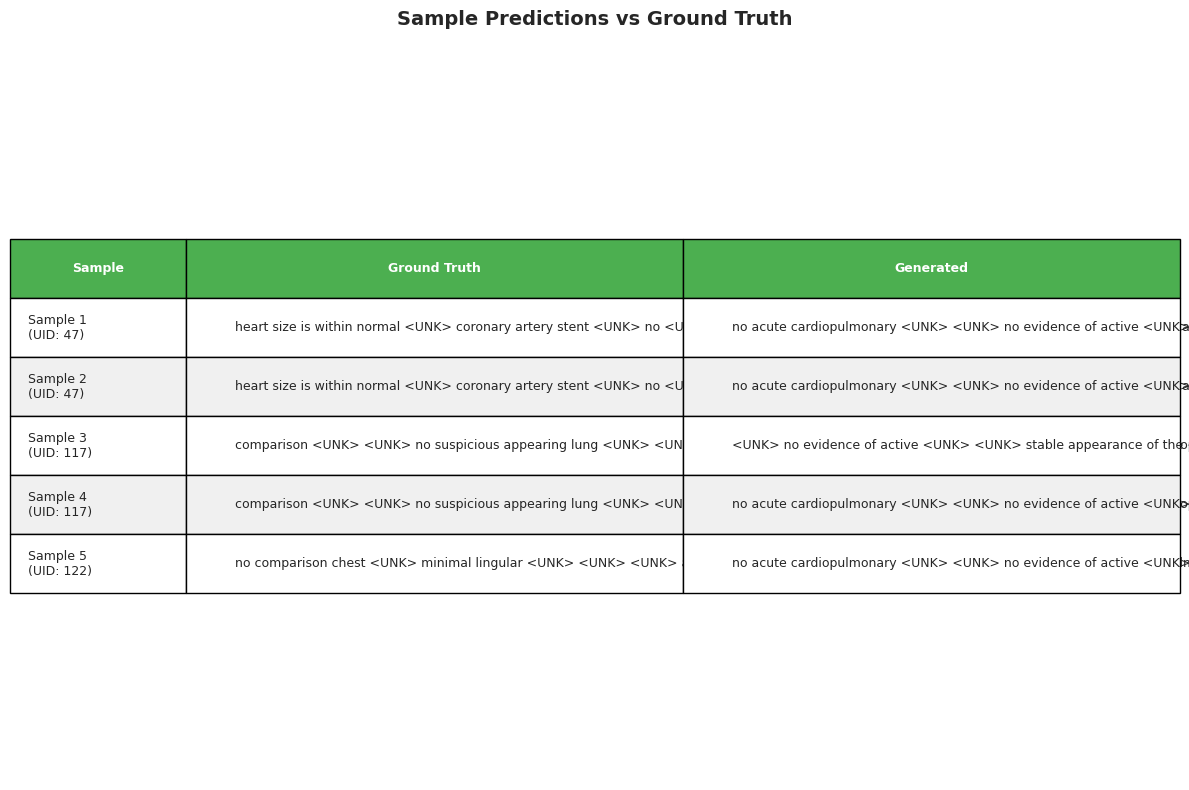


ALL SAMPLE PREDICTIONS

Sample 1 (UID: 47):
  Ground Truth: heart size is within normal <UNK> coronary artery stent <UNK> no <UNK> no focal <UNK> pleural effusion or <UNK> mild nonspecific biapical pleural <UNK> clips from prior cholecystectomy are <UNK>
  Generated:    no acute cardiopulmonary <UNK> <UNK> no evidence of active <UNK> <UNK> <UNK> <UNK> deformity of the <UNK> <UNK> <UNK> <UNK> <UNK> deformity of the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

Sample 2 (UID: 47):
  Ground Truth: heart size is within normal <UNK> coronary artery stent <UNK> no <UNK> no focal <UNK> pleural effusion or <UNK> mild nonspecific biapical pleural <UNK> clips from prior cholecystectomy are <UNK>
  Generated:    no acute cardiopulmonary <UNK> <UNK> no evidence of active <UNK> <UNK> stable appearance of the right <UNK> <UNK> a calcified <UNK> calcified <UNK> deformity of the right middle

In [15]:
# Load latest sample outputs
samples_dir = trainer.output_dir / 'sample_outputs'
sample_files = sorted(samples_dir.glob('epoch_*_samples.json'))

if sample_files:
    latest_samples_file = sample_files[-1]
    print(f"Loading samples from: {latest_samples_file.name}")
    
    with open(latest_samples_file, 'r') as f:
        samples = json.load(f)
    
    print(f"Loaded {len(samples)} sample predictions")
    
    # Plot sample predictions
    fig4 = plot_sample_predictions(
        samples=samples,
        max_samples=5,
        save_path=str(viz_dir / 'sample_predictions.png')
    )
    plt.show()
    
    # Print all samples
    print("\n" + "="*70)
    print("ALL SAMPLE PREDICTIONS")
    print("="*70)
    for i, sample in enumerate(samples, 1):
        print(f"\nSample {i} (UID: {sample['uid']}):")
        print(f"  Ground Truth: {sample['reference']}")
        print(f"  Generated:    {sample['generated']}")
else:
    print("No sample outputs found")

## 9. Final Metrics

Display best model performance and final evaluation metrics.

In [16]:
# Load training manifest
manifest_path = trainer.output_dir / 'training_manifest.json'

if manifest_path.exists():
    with open(manifest_path, 'r') as f:
        manifest = json.load(f)
    
    print("=" * 70)
    print("TRAINING SUMMARY")
    print("=" * 70)
    
    # Run info
    print(f"\nRun Information:")
    print(f"  Start time: {manifest['run_info']['start_time']}")
    if 'end_time' in manifest['run_info']:
        print(f"  End time: {manifest['run_info']['end_time']}")
        print(f"  Duration: {manifest['run_info']['duration_hours']:.2f} hours")
    
    # Hardware
    print(f"\nHardware:")
    print(f"  Device: {manifest['hardware']['device']}")
    if 'gpu_name' in manifest['hardware']:
        print(f"  GPU: {manifest['hardware']['gpu_name']}")
        print(f"  Memory: {manifest['hardware']['gpu_memory_gb']:.1f} GB")
    
    # Training summary
    if 'training_summary' in manifest:
        summary = manifest['training_summary']
        print(f"\nTraining Summary:")
        print(f"  Total epochs: {summary['total_epochs']}")
        print(f"  Total steps: {summary['total_steps']}")
        if 'best_epoch' in summary and summary['best_epoch']:
            print(f"  Best epoch: {summary['best_epoch']}")
            print(f"  Best {summary['best_metric']['name']}: {summary['best_metric']['value']:.4f}")
        
        if 'final_metrics' in summary and summary['final_metrics']:
            print(f"\n  Final Validation Metrics:")
            for metric, value in summary['final_metrics'].items():
                # Display metric with appropriate formatting
                metric_name = metric.replace('val_', '').replace('_', '-').upper()
                print(f"    {metric_name}: {value:.4f}")
else:
    print("Training manifest not found")

TRAINING SUMMARY

Run Information:
  Start time: 2026-01-06T20:11:58.277848
  End time: 2026-01-06T21:43:00.215925
  Duration: 1.52 hours

Hardware:
  Device: unknown
  GPU: unknown
  Memory: 0.0 GB

Training Summary:
  Total epochs: 25
  Total steps: 4550
  Best epoch: 15
  Best val_loss: 3.0719

  Final Validation Metrics:
    BLEU-1: 0.1088
    BLEU-2: 0.0746
    BLEU-3: 0.0530
    BLEU-4: 0.0358
    METEOR: 0.2625
    ROUGE-L: 0.1613
    LOSS: 3.0960


## 10. Load Best Model for Inference

Example of how to load the best model checkpoint for inference.

In [17]:
# Load best model checkpoint
from src.utils import CheckpointManager

checkpoint_manager = CheckpointManager(
    checkpoint_dir=str(trainer.output_dir / 'checkpoints'),
    max_checkpoints=5
)

best_checkpoint = checkpoint_manager.get_best_checkpoint()

if best_checkpoint:
    print(f"Loading best model from: {best_checkpoint}")
    
    # Create new model instance
    inference_model = EncoderDecoderModel(
        vocab_size=len(vocabulary),
        embedding_dim=config['model']['decoder']['embedding_dim'],
        encoder_feature_dim=config['model']['encoder']['output_feature_dim'],
        decoder_dim=config['model']['decoder']['hidden_dim'],
        attention_dim=config['model']['decoder']['attention']['attention_dim'],
        attention_type=config['model']['decoder']['attention']['type'],
        dropout=0.0,  # No dropout for inference
        encoder_architecture=config['model']['encoder']['architecture'],
        encoder_pretrained=False,  # Will load from checkpoint
        encoder_freeze=False
    ).to(device)
    
    # Load checkpoint
    checkpoint_info = checkpoint_manager.load_checkpoint(
        checkpoint_path=best_checkpoint,
        model=inference_model,
        device=device
    )
    
    inference_model.eval()
    
    print(f"✓ Best model loaded from epoch {checkpoint_info['epoch']}")
    print(f"  Metrics: {checkpoint_info['metrics']}")
    
    print("\nModel ready for inference!")
else:
    print("No best checkpoint found")

Loading best model from: /kaggle/working/outputs/pairs_impression_3_20260106_201158/checkpoints/best_model.pt
✓ Best model loaded from epoch 15
  Metrics: {'loss': 2.185485683954679, 'perplexity': 8.999085800988334, 'val_bleu_1': 0.10707350901525656, 'val_bleu_2': 0.07340763352522113, 'val_bleu_3': 0.05221424871535359, 'val_bleu_4': 0.035575727410747666, 'val_meteor': np.float64(0.2557473720807833), 'val_rouge_l': np.float64(0.15945177401210342), 'val_loss': 3.0718894523123037}

Model ready for inference!


In [18]:
# Example: Generate caption for random test image
if best_checkpoint:
    # Get random test sample
    test_sample_idx = np.random.randint(0, len(test_dataset))
    image, caption, caption_length, image_path, uid = test_dataset[test_sample_idx]
    
    print(f"Generating caption for test sample {test_sample_idx} (UID: {uid}):")
    print(f"  Image: {Path(image_path).name}")
    
    # Ground truth
    ground_truth = vocabulary.decode(caption.tolist())
    print(f"\nGround Truth: {ground_truth}")
    
    # Generate caption
    image_batch = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        generated_ids, scores = inference_model.generate_caption(
            image_batch,
            max_length=config['inference']['decoding']['max_length'],
            beam_size=config['inference']['decoding']['beam_size']
        )
    
    # Decode
    generated_caption = vocabulary.decode(generated_ids)
    print(f"Generated:    {generated_caption}")

Generating caption for test sample 227 (UID: 1419):
  Image: 1419_IM-0267-2001.dcm.png

Ground Truth: minimal bibasilar focal <UNK>
Generated:    heart size is normal and lungs are <UNK> no nodules or <UNK> no nodules or <UNK> no typical findings of pulmonary <UNK> no typical findings of pulmonary <UNK> no typical findings of pulmonary <UNK> no typical findings of pulmonary <UNK> no typical findings of pulmonary <UNK> no typical findings of


In [19]:
!zip -r outputs.zip /kaggle/working/outputs

  adding: kaggle/working/outputs/ (stored 0%)
  adding: kaggle/working/outputs/pairs_impression_3_20260106_201158/ (stored 0%)
  adding: kaggle/working/outputs/pairs_impression_3_20260106_201158/checkpoints/ (stored 0%)
  adding: kaggle/working/outputs/pairs_impression_3_20260106_201158/checkpoints/best_model.pt (deflated 6%)
  adding: kaggle/working/outputs/pairs_impression_3_20260106_201158/checkpoints/checkpoint_epoch_022.pt (deflated 6%)
  adding: kaggle/working/outputs/pairs_impression_3_20260106_201158/checkpoints/checkpoint_epoch_023.pt (deflated 6%)
  adding: kaggle/working/outputs/pairs_impression_3_20260106_201158/checkpoints/checkpoint_epoch_021.pt (deflated 6%)
  adding: kaggle/working/outputs/pairs_impression_3_20260106_201158/checkpoints/checkpoint_epoch_024.pt (deflated 6%)
  adding: kaggle/working/outputs/pairs_impression_3_20260106_201158/checkpoints/checkpoint_epoch_025.pt (deflated 6%)
  adding: kaggle/working/outputs/pairs_impression_3_20260106_201158/training_manif